In [1]:
!pip3 install imgaug
!pip install mlxtend
import os
import cv2
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras import backend as K
import tensorflow as tf


color = sns.color_palette()
%matplotlib inline
%config InlineBackend.figure_format="svg"

In [2]:
# Set the seed for hash based operations in python
os.environ['PYTHONHASHSEED'] = '0'

seed=1234

# Set the numpy seed
np.random.seed(seed)

# Set the random seed in tensorflow at graph level
tf.random.set_seed(seed)

# Make the augmentation sequence deterministic
aug.seed(seed)

In [3]:
training_data = Path('C:/Users/tcttn/Desktop/photos/train/') 
validation_data = Path('C:/Users/tcttn/Desktop/photos/test/')
labels_path = Path('C:/Users/tcttn/Desktop/photos/weapons.txt')

In [4]:
labels_dict= {'aircrafts':0, 'grenades':1, 'handguns':2, 'machineguns':3, 'RPG':4, 'tanks':5}

# map labels to common names
names_dict = dict(zip(labels_dict.values(), labels_dict.keys()))
print(names_dict)

{0: 'aircrafts', 1: 'grenades', 2: 'handguns', 3: 'machineguns', 4: 'RPG', 5: 'tanks'}


In [5]:
train_df = []
for folder in os.listdir(training_data):
    # Define the path to the images
    imgs_path = training_data / folder
    
    # Get the list of all the images stored in that directory
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    # Store each image path and corresponding label 
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# Creating dataframe for validation data in a similar fashion
valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
valid_df = valid_df.sample(frac=1.).reset_index(drop=True)

####################################################################################################

# How many samples do we have in our training and validation data?
print("Number of traininng samples: ", len(train_df))
print("Number of validation samples: ", len(valid_df))

# sneak peek of the training and validation dataframes
print("\n",train_df.head(), "\n")
print("=================================================================\n")
print("\n", valid_df.head())

Number of traininng samples:  7124
Number of validation samples:  1887

                                                image  label
0  C:\Users\tcttn\Desktop\photos\train\machinegun...      3
1     C:\Users\tcttn\Desktop\photos\train\RPG\69.jpg      4
2  C:\Users\tcttn\Desktop\photos\train\aircrafts\...      0
3  C:\Users\tcttn\Desktop\photos\train\handguns\2...      2
4  C:\Users\tcttn\Desktop\photos\train\aircrafts\...      0 



                                                image  label
0  C:\Users\tcttn\Desktop\photos\test\grenades\12...      1
1  C:\Users\tcttn\Desktop\photos\test\tanks\war_t...      5
2  C:\Users\tcttn\Desktop\photos\test\aircrafts\e...      0
3  C:\Users\tcttn\Desktop\photos\test\grenades\10...      1
4  C:\Users\tcttn\Desktop\photos\test\grenades\10...      1


In [6]:
# some constants(not truly though!) 

# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3

# batch size for training  
batch_size=120

# total number of classes in the dataset
nb_classes=6

In [7]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [8]:
def data_generator(data, batch_size, is_validation_data=False):
    #print("hello")
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    # Define two numpy arrays for containing batch data and labels
    batch_data = np.zeros((batch_size, img_rows, img_cols, img_channels), dtype=np.float32)
    batch_labels = np.zeros((batch_size, nb_classes), dtype=np.float32)
    
    while True:
        if not is_validation_data:
            # shuffle indices for the training data
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                #print(data.iloc[idx]["image"])
                img = cv2.imread(data.iloc[idx]["image"])
                #print(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                #print(data.iloc[idx]["label"])
                label = data.iloc[idx]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                #print(img.size)
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            #print(preprocess_input(batch_data))
            batch_data = preprocess_input(batch_data)
            yield batch_data, batch_labels

In [9]:
train_data_gen = data_generator(train_df, batch_size)

# validation data generator 
valid_data_gen = data_generator(valid_df, batch_size, is_validation_data=True)

In [10]:
# simple function that returns the base model
def get_base_model():
    base_model = VGG16(input_shape=(img_rows, img_cols, img_channels), weights='imagenet', include_top=True)
    return base_model

In [11]:
# get the base model
base_model = get_base_model()

#  get the output of the second last dense layer 
base_model_output = base_model.layers[-2].output

# add new layers 
x = Dropout(0.7,name='drop2')(base_model_output)
output = Dense(6, activation='softmax', name='fc3')(x)

# define a new model 
model = Model(base_model.input, output)

# Freeze all the base model layers 
for layer in base_model.layers[:-1]:
    layer.trainable=False

# compile the model and check it 
optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [12]:
# always user earlystopping
# the restore_best_weights parameter load the weights of the best iteration once the training finishes
es = EarlyStopping(patience=10, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="model1", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(train_df)/batch_size))
nb_valid_steps = int(np.ceil(len(valid_df)/batch_size))

# number of epochs 
nb_epochs=10

In [13]:
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_data_gen, 
                              validation_steps=nb_valid_steps,
                              callbacks=[es,chkpt])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
60/60 [==============================] - ETA: 0s - loss: 0.7253 - accuracy: 0.8181 WARNING:tensorflow:From C:\Anaconda3\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model1\assets
60/60 [==============================] - 1342s 22s/step - loss: 0.7253 - accuracy: 0.8181 - val_loss: 0.2549 - val_accuracy: 0.9245
Epoch 2/10
60/60 [==============================] - 1309s 22s/step - loss: 0.3605 - accuracy: 0.9050 - val_loss: 0.3091 - val_accuracy: 0.9208
Epoch 3/10
60/60 [========================

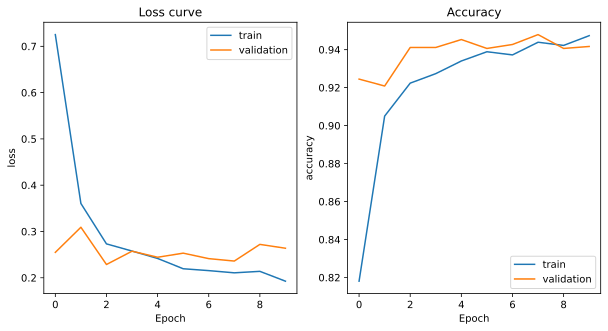

In [16]:
train_acc = history1.history['accuracy']
valid_acc = history1.history['val_accuracy']

# get the loss
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']

# get the number of entries
xvalues = np.arange(len(train_acc))

# visualize
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

In [17]:
# What is the final loss and accuracy on our validation data?
valid_loss, valid_acc = model.evaluate_generator(valid_data_gen, steps=nb_valid_steps)
print(f"Final validation accuracy: {valid_acc*100:.2f}%")

Instructions for updating:
Please use Model.evaluate, which supports generators.
Final validation accuracy: 94.17%


In [18]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# check if we have all the layers we require for visualization 
vis_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [19]:
# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3']


In [130]:
def get_CAM(processed_image, predicted_label):
    """
    This function is used to generate a heatmap for a sample image prediction.
    
    Args:
        processed_image: any sample image that has been pre-processed using the 
                       `preprocess_input()`method of a keras model
        predicted_label: label that has been predicted by the network for this image
    
    Returns:
        heatmap: heatmap generated over the last convolution layer output 
    """
    # we want the activations for the predicted label
    print(model.output)
    predicted_output = model.output[:, predicted_label]
    
    # choose the last conv layer in your model
    last_conv_layer = model.get_layer('block5_conv3')
    
    # get the gradients wrt to the last conv layer
    grads = K.gradients(predicted_output, last_conv_layer.output)[0]
    
    # take mean gradient per feature map
    grads = K.mean(grads, axis=(0,1,2))
    
    # Define a function that generates the values for the output and gradients
    evaluation_function = K.function([model.input], [grads, last_conv_layer.output[0]])
    
    # get the values
    grads_values, conv_ouput_values = evaluation_function([processed_image])
    
    # iterate over each feature map in yout conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_ouput_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_ouput_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    return heatmap

In [131]:
def show_random_sample(idx):
    """
    This function is used to select a random sample from the validation dataframe.
    It generates prediction for the same. It also stores the heatmap and the intermediate
    layers activation maps.
    
    Arguments:
        idx: random index to select a sample from validation data
    
    Returns:
        activations: activation values for intermediate layers
    """
    # select the sample and read the corresponding image and label
    sample_image = cv2.imread(valid_df.iloc[idx]['image'])
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = cv2.resize(sample_image, (img_rows, img_cols))
    sample_label = valid_df.iloc[idx]["label"]
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    #print(np.expand_dims(sample_image, axis=0))
    sample_image_processed = preprocess_input(sample_image_processed)
    #print(preprocess_input(sample_image_processed))
    
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
    #print(vis_model.predict(sample_image_processed))
    
    # get the label predicted by our original model
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    #print(pred_label)
    
    # choose any random activation map from the activation maps 
    sample_activation = activations[0][0,:,:,32]
    #print(sample_activation)
    
    # normalize the sample activation map
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    # convert pixel values between 0-255
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    
    
    # get the heatmap for class activation map(CAM)
    #print(sample_image_processed)
    #print(pred_label)
    heatmap = get_CAM(sample_image_processed, pred_label)
    #print(heatmap)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

    f,ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.show()
    
    return activations

In [132]:
activations= show_random_sample(100)

3
Tensor("fc3/Softmax:0", shape=(None, 6), dtype=float32)


RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [121]:
def visualize_intermediate_activations(layer_names, activations):
    """
    This function is used to visualize all the itermediate activation maps
    
    Arguments:
        layer_names: list of names of all the intermediate layers we chose
        activations: all the intermediate activation maps 
    """
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

In [122]:
# visualize all the activation maps for this sample
visualize_intermediate_activations(activations=activations, layer_names=layer_names)

NameError: name 'activations' is not defined

In [123]:
sample_idx=200
activations= show_random_sample(sample_idx)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [124]:
sample_idx=10
activations= show_random_sample(sample_idx)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [125]:
sample_idx=55
activations= show_random_sample(sample_idx)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

In [126]:
sample_idx=70
activations= show_random_sample(sample_idx)

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.